# Integrated Energy Systems: Nuclear Case Study with TEAL Cashflows


Before running this notebook, we have to get RAVEN and DISPATCHES to play along together. 
The easiest way, as of 8/19/2022, is to first install RAVEN and all its dependencies into a dedicated conda environment. 
Then install DISPATCHES within that environment. Installation guides for [RAVEN](github.com:idaholab/raven.git) and [DISPATCHES](https://github.com/gmlc-dispatches/dispatches) can be found in their respective Github repositories, but the major steps are summarized below:

  ```bash
  # assuming git cloning with SSH key, can substitute HTML cloning
  git clone git@github.com:idaholab/raven.git
  git clone git@github.com:gmlc-dispatches/dispatches.git

  cd raven

  # if you haven't installed RAVEN yet:
  ./scripts/establish_conda_env.sh --install
  # else, activate the environment
  conda activate raven_libraries

  # load raven libraries (if on Windows and using Anaconda Prompt, run 'conda install m2-base' to get sh command)
  sh ./scripts/establish_conda_env.sh --load

  cd ../dispatches 

  # usually got an SSL certificate error, fix is to add github to trusted hosts
  python -m pip install -r requirements-dev.txt --trusted-host=codeload.github.com

  ```




In [1]:
# General python imports
import json

# Pyomo imports
from pyomo.environ import (ConcreteModel,
                           RangeSet,
                           Var,
                           NonNegativeReals,
                           Constraint,
                           Expression,
                           Objective,
                           maximize,
                           units as pyunits)

# IDAES imports
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom

# Nuclear flowsheet function imports
from dispatches.case_studies.nuclear_case.nuclear_flowsheet import (build_ne_flowsheet,
                                                                    fix_dof_and_initialize)

# Import function for the construction of the multiperiod model
from dispatches.case_studies.nuclear_case.multiperiod import (
    build_multiperiod_design,
    plot_lmp_and_schedule)

### TEAL: Adding TEAL to path and importing Cashflows 

Note you have to run this using the *raven_libraries* Python environment for now. Within that environment, you should install *dispatches*

In [2]:
import os.path as path 
import os, sys
cwd = os.getcwd()
proj_dir = path.dirname( path.abspath( path.join(cwd, '../../..') ) )
TEAL_dir = path.abspath( path.join(proj_dir, 'TEAL') )
raven_dir = path.abspath( path.join(proj_dir, 'raven') )
sys.path.append( proj_dir )
sys.path.append( TEAL_dir )
sys.path.append( raven_dir )
sys.path.append( path.abspath( path.join(TEAL_dir, 'src') ) )

from TEAL.src import CashFlows
from TEAL.src import main as RunCashFlow

## Simulation of the Flowsheet

Before we formulate the multiperiod optimization problem, we first simulate the nuclear flowsheet and print some results. This helps the reader to familiarize themselves with the names, along with their default units, of a few important variables. The readers are encouraged to go through the `nuclear_flowsheet.py` script. It contains the function `build_ne_flowsheet` which assembles models for all the units in the flowsheet, and connects them via `Arc` objects. It also contains the function `fix_dof_and_initialize` which fixes the degrees of freedom and initializes the entire flowsheet.

The flowsheet has four degrees of freedom viz.,

- Split fraction of electricity to the grid in the power splitter (variable `m.fs.np_power_split.split_fraction["np_to_grid", 0]` in the model). We fix this variable to 0.8.
- Molar flowrate of hydrogen to the pipeline (variable `m.fs.h2_tank.outlet_to_pipeline.flow_mol[0]`). We fix this variable to 10 mol/s.
- Molar flowrate of hydrogen to the turbine (variable `m.fs.h2_tank.outlet_to_turbine.flow_mol[0]`). We fix this variable to 10 mol/s.
- Initial holdup of hydrogen in the tank (variable `m.fs.h2_tank.tank_holdup_previous[0]`). We fix this variable to 0 mol.

These variables are fixed in the `fix_dof_and_initialize` function. In addition to the above three variables, we also fix the variables shown in the table below. We do not refer these variables as degrees of freedom, because they remain fixed at these values in the multiperiod optimization model.

| Name | Variable | Value |
| :- | :- | :-: |
| Pressure difference across `h2_turbine`'s compressor | `m.fs.h2_turbine.compressor.deltaP` | 24.01 bar |
| Isentropic efficiency of `h2_turbine`'s compressor   | `m.fs.h2_turbine.compressor.efficiency_isentropic` | 0.86 |
| Conversion of hydrogen in `h2_turbine`'s reactor     | `m.fs.h2_turbine.stoic_reactor.conversion`         | 0.99 |
| Pressure deifference across `h2_turbine`'s turbine   | `m.fs.h2_turbine.turbine.deltaP` | -24.01 bar |
| Isentripic efficiency of `h2_turbine`'s turbine      | `m.fs.h2_turbine.turbine.efficiency_isentropic`  | 0.89 |
| Molar flow rate of air to `h2_turbine`               | `m.fs.mixer.air_feed.flow_mol[0]`  | 10.76 * molar flowrate of hydrogen to turbine |
| Temperature of air | `m.fs.mixer.air_feed.temperature[0]` | 300 K |
| Pressure of air |  `m.fs.mixer.air_feed_pressure[0]`  | 1.01325 bar |
| Duration of the simulation for `h2_tank` | `m.fs.h2_tank.dt`  | 3600 s |


In [3]:
# Create a concrete model object
m = ConcreteModel()

# Build the nuclear flowsheet
build_ne_flowsheet(m)

# Fix the degrees of freedom and initialize
fix_dof_and_initialize(m)

# Ensure that the resulting model is a square problem i.e., its degrees of freedom must be 0
print("Degrees of freedom: ", degrees_of_freedom(m))
assert degrees_of_freedom(m) == 0

# Create a solver object with the default solver (IPOPT)
solver = get_solver()

# Simulate the entire flowsheet
solver.solve(m, tee=True)

2022-08-29 06:28:07 [INFO] idaes.init.fs.pem.outlet_state: Starting initialization
2022-08-29 06:28:07 [INFO] idaes.init.fs.pem.outlet_state: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:28:07 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_in: Starting initialization
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Starting initialization
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Property package initialization: optimal - Optimal Solution Found.
2022-08-29 06:28:07 [INFO] idaes.init.fs.h2_tank.properties_out_pipeline: Starting initializa

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 215, 'Number of variables': 215, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.7\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.16513776779174805}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Verify that IPOPT converges to the optimal solution. Next, we print some results. Note the names of the variables and their default units (we use Pyomo's `units`, imported as `pyunits`, to obtain the units of a variable). Units are needed to correctly define the cash flow expressions later.

In [4]:
def get_units(obj):
    return str(pyunits.get_units(obj))

# Print results: power splitter
print("Nuclear plant power production : ", m.fs.np_power_split.electricity[0].value,
      get_units(m.fs.np_power_split.electricity[0]))
print("Electricity to grid            : ", m.fs.np_power_split.np_to_grid_port.electricity[0].value,
      get_units(m.fs.np_power_split.np_to_grid_port.electricity[0]))
print("Electricity to PEM             : ", m.fs.np_power_split.np_to_pem_port.electricity[0].value,
      get_units(m.fs.np_power_split.np_to_pem_port.electricity[0]))
print()

# Print results: PEM electrolyzer
print("Flowrate of H2 from pem        : ", m.fs.pem.outlet.flow_mol[0].value,
      get_units(m.fs.pem.outlet.flow_mol[0]))
print()

# Print results: Hydrogen tank
print("Flowrate of H2 to tank         : ", m.fs.h2_tank.inlet.flow_mol[0].value,
      get_units(m.fs.h2_tank.inlet.flow_mol[0]))
print("Flowrate of H2 to pipeline     : ", m.fs.h2_tank.outlet_to_pipeline.flow_mol[0].value,
      get_units(m.fs.h2_tank.outlet_to_pipeline.flow_mol[0]))
print("Flowrate of H2 to turbine      : ", m.fs.h2_tank.outlet_to_turbine.flow_mol[0].value,
      get_units(m.fs.h2_tank.outlet_to_turbine.flow_mol[0]))
print("Initial tank holdup            : ", m.fs.h2_tank.tank_holdup_previous[0].value,
      get_units(m.fs.h2_tank.tank_holdup_previous[0]))
print("Tank holdup at the end of 1 hr : ", m.fs.h2_tank.tank_holdup[0].value,
      get_units(m.fs.h2_tank.tank_holdup[0]))

# Print results: Hydrogen Turbine
print("H2 Turbine's compressor work   : ", m.fs.h2_turbine.compressor.work_mechanical[0].value,
      get_units(m.fs.h2_turbine.compressor.work_mechanical[0]))
print("H2 Turbine's turbine work      : ", m.fs.h2_turbine.turbine.work_mechanical[0].value,
      get_units(m.fs.h2_turbine.turbine.work_mechanical[0]))
print("Net power produced by turbine  : ", (- m.fs.h2_turbine.turbine.work_mechanical[0].value
                                            - m.fs.h2_turbine.compressor.work_mechanical[0].value),
      get_units(m.fs.h2_turbine.compressor.work_mechanical[0]))

Nuclear plant power production :  1000000.0 kW
Electricity to grid            :  800000.0 kW
Electricity to PEM             :  199999.99999999997 kW

Flowrate of H2 from pem        :  505.4811999999999 mol/s

Flowrate of H2 to tank         :  505.4811999999999 mol/s
Flowrate of H2 to pipeline     :  10 mol/s
Flowrate of H2 to turbine      :  10 mol/s
Initial tank holdup            :  0 mol
Tank holdup at the end of 1 hr :  1747732.3199999996 mol
H2 Turbine's compressor work   :  1764604.5955977994 kg*m**2/s**3
H2 Turbine's turbine work      :  -2672169.126200441 kg*m**2/s**3
Net power produced by turbine  :  907564.5306026414 kg*m**2/s**3


Observe that the power variables in the power splitter model and the PEM electrolyzer model use kW. Whereas, the power variables (mechanical work) use in the hydrogen turbine model use W. This complete the simulation of the flowsheet. Before proceeding further, we delete the object `m` to avoid confusion

In [5]:
# Delete the object containing the flowsheet
del m

## Multiperiod Optimization Model: Deterministic

### LMP Signal
Our objective is to determine the optimal size of the PEM, tank and turbine maximizing the NPV for a given 'market signal'. Throughout the notebook, by market signal or price signal, we refer to the locational marginal price (LMP) (selling price of electricity, in $/MWh) as a function of time. The LMP depends on several factors such as weather, demand, generator mix of the grid, and so forth. Owing to the uncertain nature of some those factors, it is not possible to predict the exact value of the LMP way into the future. Nevertheless, in this section, we **assume that the LMP signal is accurate** (i.e., there is no uncertainty in the price). Later, we show how the same framework/workflow can be used to easily formulate a stochastic program to handle the uncertainty in the price signal. 

Here, we use the LMP data contained in the file `lmp_signal.json`. This dataset is generated by FORCE (link goes here) using the 2019/2020 New York Independent System Operator (NYISO) price data. FORCE divides the 365 days of a year into a specified number of clusters (20, in our case), and generates the LMP signal for each cluster (Note that the LMP signal is the same for all the days of a cluster). The figure below plots the LMP signal for cluster 1 (left) and cluster 8.

![](sample_lmp_plots.png)

As evident from the figure, the price can vary significantly in a day, and from cluster to cluster. Given the variation, we are interested in determining if producing hydrogen, especially during the periods when LMP is low, is attractive or not. 

For the demonstration, we do not use the entire dataset in `lmp_signal.json`. Instead, we use the LMP signal only for the years 2022 and 2032. We assume that the plant lifetime is twenty years. We use the 2022 LMP signal for the first ten years (i.e., 2022 - 2031), and the 2032 LMP signal for the next ten years (i.e., 2032 - 2041). If desired, the LMP data for the intermediate years can be easily included in the model with a slight modification to the code.

In [6]:
# Load the LMP dataset
with open("lmp_signal.json") as fp:
    lmp_dataset = json.load(fp)
    
# Gather the LMP data needed for the deterministic case
# Notation: lmp_dataset[scenario][year][cluster/day][time/hour]
lmp_deterministic = {year: {cluster: {hour: lmp_dataset["0"][str(year)][str(cluster)][str(hour)]
                                      for hour in range(1, 25)} 
                            for cluster in range(1, 21)}
                     for year in [2022, 2032]}

# Size of each cluster/number of days in a year represented by the cluster
weights_days = {year: {cluster: lmp_dataset[str(0)][str(year)][str(cluster)]["num_days"]
                       for cluster in range(1, 21)}
                for year in [2022, 2032]}


Now, we formulate the multi-period price-taker problem to determine the optimal design and operating decisions maximizing the NPV. The optimization problem is of the form
$$ \begin{aligned}
\max_{D, u_{t, d}} \quad & \text{NPV}(D, u_{t, d})\\
& g(u_{t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}  \\
& h(u_{t, d}) \le 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}  \\
& f(u_{t-1,d}, u_{t,d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C} \\
& u_{t,d} \le D, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}
\end{aligned}$$

Here, the sets $\mathcal{T} = \{1, \dots, 24\}$ and $\mathcal{C} = \{1, \dots, 20\}$ denote the set of hours in a day and the set of clusters/days in a year, respectively. $D$ denotes the design decisions (or, first-stage variables) viz. size of the PEM electrolyzer (`pem_capacity`), tank (`tank_capacity`) and the turbine (`turbine_capacity`). $u_{t, d}$ denotes the operating decisions (or, second-stage decisions) at time $t$ of day/cluster $d$. $g(u_{t, d}) = 0$ and $h(u_{t,d}) \le 0$ denote the flowsheet model, $f(u_{t-1,d}, u_{t,d}) = 0$ connects the operating decisions at time $t-1$ and at time $t$ (e.g., tank holdup), and $u_{t,d} \le D$ ensures that the operating decision values never exceed the design capacity values (e.g., tank holdup at any time instant must not exceed the tank capacity).

First, we create a `ConcreteModel` object, and define sets and parameters

In [7]:
# Create a ConcreteModel object
m = ConcreteModel()

# Define sets
m.set_time = RangeSet(24)                    # twenty fours in a day
m.set_days = RangeSet(20)                    # twenty clusters/days per year
m.set_years = [2022, 2032]                   # Set of years

# Define parameters
m.plant_life = 20                            # Plant lifetime: 20 years
m.tax_rate = 0.2                             # Corporate tax rate: 20%
m.discount_rate = 0.08                       # Discount rate: 8%
m.h2_price = 3                               # Selling price of hydrogen: $3/kg
m.h2_demand = 1                              # Maximum amount of hydrogen that can be sold: 1 kg/s
m.LMP = lmp_deterministic                    # LMP signal
m.weights_days = weights_days                # number of days represented by each cluster

This might be a temporary cell, but checking to see if the amount of years supplied by the LMP data match the desired project length/plant life.
In the future, project length and plant lifetime should be separate entities. 
Should also figure out multiplicity (least common multiple) of plant lives. 

In [8]:
# checking if number of years provided in data match plant_life
import numpy as np

# list of available years in LMP data
years = list( m.LMP.keys() )
n_years_data = len(years)

# template dictionary full of 0s, same structure as LMP
zeroDict = {cluster: {hour: 0
                    for hour in m.set_time} 
              for cluster in m.set_days}

## CHECKING THAT WE HAVE ENOUGH DATA FOR SIM ##

# Case where we have less data than the project life/sim time
#    Here, we assume (as in the default nuclear case demo) that
#    the years 2022-2031 all have the same LMP data, which
#    helps to cut down on variables just for the demonstration
if n_years_data < m.plant_life:
  print("LMP Data less than project life")
  projLifeRange = np.arange( years[0]-1,   # year-1 is the construction year
                    years[0] + m.plant_life) # full project time with first year of data as starting point

  # initializing empty dicts and lists
  newLMP      = {} # going to replace existing LMP dictionary
  newYearsVec = [] # list of years used
  stuckYear   = 0  # ugly way of duplicating years

  # looping through possible years in lifetime (e.g., 2021 -> 2041)
  for i,y in enumerate(projLifeRange):
    # data not available for given year within project lifetime
    if y not in years:
      if i == 0: # construction year
        newLMP[y] = zeroDict
        newYearsVec.append(0)
      else: # duplicate previous year's values
        newLMP[y] = newLMP[y-1]
        newYearsVec.append(stuckYear)
    # data for current year is available in LMP dict
    else:
      stuckYear = y # update year for duplication (word?)
      newLMP[y] = m.LMP[y] # keep current LMP value
      newYearsVec.append(y) # update current year
  
  # save to model object
  m.LMP = newLMP
  m.yearsFullVec = newYearsVec

elif n_years_data > m.plant_life:
  print("LMP Data more than project life, must curtail.")
  # TODO fill this out
else:
  print("LMP Data matches project life")
  # TODO fill this out
  # years.insert(0,0)

LMP Data less than project life


As we saw earlier, functions `build_ne_flowsheet` and `fix_dof_and_initialize` yield an initialized square model of the nuclear flowsheet. For the multi-period optimization problem, we now construct a function that can be used to unfix a few degrees of freedom for optimization. The function below

- Unfixes the split fractions of the power splitter. The optimizer then determines the optimal split fraction of the electricity to the grid, and to the PEM electrolyzer.
- Unfixes the initial tank holdup. The initial tank holdup is governed by the final tank holdup at the previous hour.
- Unfixes the molar flow rate of hydrogen to the turbine and to the pipeline.
- Unfixes the molar flow rate of air to the turbine.
- Adds a constraint to fix the ratio of molar flow rate of air to molar flowrate of hydrogen (fuel-air ratio).
- Specifies a small non-zero bounds on a few flow variables to avoid convergence issues.

In [9]:
def unfix_dof(m, **kwargs):
    """
    This function unfixes a few degrees of freedom for optimization
    """
    # Set defaults in case options are not passed to the function
    options = kwargs.get("options", {})
    air_h2_ratio = options.get("air_h2_ratio", 10.76)
    
    # Unfix the electricity split in the electrical splitter
    m.fs.np_power_split.split_fraction["np_to_grid", 0].unfix()

    # Unfix the holdup_previous and outflow variables
    m.fs.h2_tank.tank_holdup_previous.unfix()
    m.fs.h2_tank.outlet_to_turbine.flow_mol.unfix()
    m.fs.h2_tank.outlet_to_pipeline.flow_mol.unfix()

    # Unfix the flowrate of air to the mixer
    m.fs.mixer.air_feed.flow_mol.unfix()

    # Add a constraint to maintain the air to hydrogen flow ratio
    m.fs.mixer.air_h2_ratio = Constraint(
        expr=m.fs.mixer.air_feed.flow_mol[0] ==
             air_h2_ratio * m.fs.mixer.hydrogen_feed.flow_mol[0])
    
    # Set bounds on variables. A small non-zero value is set as the lower 
    # bound on molar flowrates to avoid convergence issues
    m.fs.pem.outlet.flow_mol[0].setlb(0.001)

    m.fs.h2_tank.inlet.flow_mol[0].setlb(0.001)
    m.fs.h2_tank.outlet_to_turbine.flow_mol[0].setlb(0.001)
    m.fs.h2_tank.outlet_to_pipeline.flow_mol[0].setlb(0.001)

    m.fs.translator.inlet.flow_mol[0].setlb(0.001)
    m.fs.translator.outlet.flow_mol[0].setlb(0.001)

    m.fs.mixer.hydrogen_feed.flow_mol[0].setlb(0.001)

Next, we use the `build_multiperiod_design` function to build the constraints $g(u_{t,d}) = 0$ and $h(u_{t,d}) \le 0$ $\forall \; t \in \mathcal{T}$ and $\forall \; d \in \mathcal{C}$. This function creates an instance of the flowsheet (using the `build_ne_flowsheet` function) for each time instance, fixes its degrees of freedom and initializes it (using the `fix_dof_and_initialize` function), and unfixes operational degrees of freedom (using the `unfix_dof` function) described above. Since we are dealing with multiple days/clusters and multiple years (2022 and 2032 LMP signals), we set the `multiple_days` and `multiyear` argument to `True` (see below. Note that the default value of these arguments is `False`). 

**Note**: The function, by default, looks for `m.set_time`, `m.set_days` and `m.set_years` objects for the set of hours, days/clusters and years, respectively. However, if the sets are created using a different set of names, then they must be passed to the function explicitly. E.g. `build_multiperiod_design(m, ..., set_time=m.set_time_object, set_days=m.set_days_object, set_years=m.set_years_object)`.

**Tip**: Building the multiperiod model can take some time. So, set `verbose=True` to moniter the progress

In [10]:
# Build initialized multiperiod model: Constraints g(u(t,d)) = 0 and h(u(t,d)) <= 0
build_multiperiod_design(m,
                         flowsheet=build_ne_flowsheet,
                         initialization=fix_dof_and_initialize,
                         unfix_dof=unfix_dof,
                         multiple_days=True,
                         multiyear=True,
                         verbose=False)

[    0.00] Processing input information.
[+   0.00] Beginning the formulation of the multiperiod problem.
[+ 215.91] Completed the formulation of the multiperiod problem
2022-08-29 06:31:48 [INFO] idaes.init.fs.pem.outlet_state: Starting initialization
2022-08-29 06:31:48 [INFO] idaes.init.fs.pem.outlet_state: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:31:48 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-08-29 06:31:48 [INFO] idaes.init.fs.h2_tank.properties_in: Starting initialization
2022-08-29 06:31:49 [INFO] idaes.init.fs.h2_tank.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:31:49 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Starting initialization
2022-08-29 06:31:49 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:31:49 [INFO] idaes.init.fs.h2_tank.properties_out

Next, we define 

- Function `build_connecting_constraints` to declare the design decisions and to build the constraints $f(u_{t-1,d}, u_{t,d}) = 0$ and $u_{t,d} \le D$. 
- Function `append_costs_and_revenue` to build expressions for all the cash flows (electricity revenue, hydrogen revenue, fixed O&M, variable O&M, depreciation, etc.)

Observe that we assume (Line 39 in the function below) that each day begins with an empty tank (i.e., zero holdup). This is one of the limitations of working with representative days/clusters. The excess storage at the end of each day cannot be transferred to the following day. This limitation can be overcome by formulating an optimization problem for an entire year, instead of a few representative days. This, however, increases the problem size substantially.

**Note**: It is not necessary to define the above functions for the deterministic case. Nevertheless, we do so because it will be useful for the stochastic case, as we shall see in the next section.

In [11]:
def build_connecting_constraints(m, set_time, set_days, set_years):
    
    """
    This function declares the first-stage variables or design decisions,
    adds constraints that ensure that the operational variables never exceed their
    design values, and adds constraints connecting variables at t - 1 and t
    """

    # Declare first-stage variables (Design decisions)
    m.pem_capacity = Var(within=NonNegativeReals,
                         doc="Maximum capacity of the PEM electrolyzer (in kW)")
    m.tank_capacity = Var(within=NonNegativeReals,
                          doc="Maximum holdup of the tank (in mol)")
    m.h2_turbine_capacity = Var(within=NonNegativeReals,
                                doc="Maximum power output from the turbine (in W)")

    # Ensure that the electricity to the PEM elctrolyzer does not exceed the PEM capacity
    @m.Constraint(set_time, set_days, set_years)
    def pem_capacity_constraint(blk, t, d, y):
        return blk.period[t, d, y].fs.pem.electricity[0] <= m.pem_capacity

    # Ensure that the final tank holdup does not exceed the tank capacity 
    @m.Constraint(set_time, set_days, set_years)
    def tank_capacity_constraint(blk, t, d, y):
        return blk.period[t, d, y].fs.h2_tank.tank_holdup[0] <= m.tank_capacity

    # Ensure that the power generated by the turbine does not exceed the turbine capacity
    @m.Constraint(set_time, set_days, set_years)
    def turbine_capacity_constraint(blk, t, d, y):
        return (
            - blk.period[t, d, y].fs.h2_turbine.turbine.work_mechanical[0]
            - blk.period[t, d, y].fs.h2_turbine.compressor.work_mechanical[0] <=
            m.h2_turbine_capacity
        )

    # Connect the initial tank holdup at time t with the final tank holdup at time t - 1
    @m.Constraint(set_time, set_days, set_years)
    def tank_holdup_constraints(blk, t, d, y):
        if t == 1:
            # Each day begins with an empty tank
            return (
                blk.period[t, d, y].fs.h2_tank.tank_holdup_previous[0] == 0
            )
        else:
            # Initial holdup at time t = final holdup at time t - 1
            return (
                blk.period[t, d, y].fs.h2_tank.tank_holdup_previous[0] ==
                blk.period[t - 1, d, y].fs.h2_tank.tank_holdup[0]
            )

Next, we use the numbers in the table below for constructing the cash flow expressions.

| Unit | CAPEX | Fixed O&M | Variable O&M |
| :- | :-: | :-: | :-: |
| PEM Electrolyzer | \$1630 /kW | \$47.9 /kW | \$1.3 /MWh |
| Hydrogen tank | \$29 /kWh  |  0 |  0 |
| Hydrogen turbine | \$947 /kW  | \$7 /kW | \$4.25 /Mwh|

We refer the reader to the Simulation of the Flowsheet section for the default units of the decision variables. We convert the cost numbers so that the units are consistent with that of the variable.

### TEAL: Defining component costs/revenues and corresponding IDAES variables 

We now add a template dictionary with all the Nuclear Case components. 
Each plant component has nested dictionaries for each desired TEAL cash flow. 
Note that all cash flows are defined as:
  $$C_y = m \alpha_y \bigg(\frac{D_y}{R}\bigg)^X$$
The cash flow $C_y$ is indexed by year, but hourly indeces can also be created and summed per year. Other parameters include $\alpha$, the reference price, $D_y$ the driver for the cash flow (e.g., number of units sold, hours of electricity produced, etc.), $R$ the reference driver corresponding to $\alpha$ (optional), $X$ the scaling factor, and $m$ an extra multiplier.


The cash flow dictionaries below must have:
1. an **Expression**: a list of strings of the Pyomo variable name used as the cash flow driver ($D_y$)
2. a **Value**: the cost per unit ($\alpha$)
3. a **Multiplier**: an extra multiplier to distinguish between +/- cash flows ($m$)

Each component must also have a Lifetime but all currently set to be the same. 

In [12]:
components={
  # Electrolyzer: negative Cash flows
  "pem":{ 
    "Lifetime": 20,
    "Capex":{
        "Expressions": ['pem_capacity'],
        "Value": 1630, # $/kW
        "Multiplier": [-1],
    },
    "FixedOM":{
      "Expressions": ['pem_capacity'],
      "Value": 47.9, # $/kW
      "Multiplier": [-1],
    },
    "Hourly":{
      "Expressions": ['fs.pem.electricity'],
      "Value": 1.3e-3, # $/MWh -> $/kWh
      "Multiplier": [-1],
    },
  },
  # Hydrogen Tank: negative Cash flows
  "h2tank":{
    "Lifetime": 20,
    "Capex":{
      "Expressions": ['tank_capacity'],
      "Value": 1.946851199, # $29/kWh * 33.3 kWh/kg * 2.016e-3 kg/mol
      "Multiplier": [-1],
    },
  },
  # Hydrogen Turbine: negative Cash flows
  "h2turbine":{ 
    "Lifetime": 20,
    "Capex":{
      "Expressions": ['h2_turbine_capacity'],
      "Value": 0.947, # $/kW -> $/W
      "Multiplier": [-1],
    },
    "FixedOM":{
      "Expressions": ['h2_turbine_capacity'],
      "Value": 0.007, # $/kW -> $/W
      "Multiplier": [-1],
    },
    "Hourly":{
      "Expressions": ['fs.h2_turbine.turbine.work_mechanical',
        'fs.h2_turbine.compressor.work_mechanical'],
      "Value": 4.25e-6, # $/MWh -> $/Wh
      "Multiplier": [1, 1], # these values come out with correct sign in expression
    },
  },
  # Electricity Market: positive Cash flows
  "electricity_market":{
    "Lifetime": 20,
    "Hourly":{
      "Expressions": ['fs.np_power_split.np_to_grid_port.electricity',
        'fs.h2_turbine.turbine.work_mechanical',
        'fs.h2_turbine.compressor.work_mechanical'],
      "Value": [], # this is LMP in $/MWh, should be path str to ROM
      "Multiplier": [1e-3, -1e-6, -1e-6], # converting to $/kWh and $/Wh
    },
  },
  # Hydrogen Market: positive Cash flows
  "h2_market":{
    "Lifetime": 20,
    "Hourly":{
      "Expressions": ['fs.h2_tank.outlet_to_pipeline.flow_mol'], # this is in mol/s
      "Value": 3.0, # this is $/kg
      "Multiplier":  [7.2576] # convert from $/kg -> $/mol and also converting mol/s to mol/hr
    },
  },
}

TEAL: Next, we should initialize global Cash flow attributes within TEAL.

This includes passing discount rates, plant life, etc. from the notebook to an object of TEAL 
global parameters. 

In [13]:
import numpy as np
import operator

# *** HELPER FUNCTIONS / repurposed from TEAL/tests/PyomoTest.py ***
def build_econ_settings(cfs, life=5, dr=0.1, tax=0.21, infl=0.02184):
  """
    Constructs global settings for econ run
    @ In, cfs, CashFlow, cash flow components
    @ In, life, float, life time of the years to evaluate
    @ In, dr, float, discount rate
    @ In, tax, float, the amount of tax ratio to apply
    @ In, infl, float, the amount of inflation ratio to apply
    @ Out, settings, CashFlow.GlobalSettings, settings
  """
  active = []
  for comp_name, cf_list in cfs.items():
    for cf in cf_list:
      active.append(f'{comp_name}|{cf}')
  print(active)
  params = {'DiscountRate': dr,
            'tax': tax,
            'inflation': infl,
            'ProjectTime': life,
            'Indicator': {'name': ['NPV'], # TODO: check IRR, PI
                          'active': active}
           }
  settings = CashFlows.GlobalSettings()
  settings.setParams(params)
  settings._verbosity = 0
  return settings


# using full plant life = 20 yrs
# LMP signal only uses 2 years... need to resolve when creating recurring cash flows
tealSettings = build_econ_settings(components,
                                    life=m.plant_life,
                                    dr=m.discount_rate,
                                    tax=m.tax_rate)

['pem|Lifetime', 'pem|Capex', 'pem|FixedOM', 'pem|Hourly', 'h2tank|Lifetime', 'h2tank|Capex', 'h2turbine|Lifetime', 'h2turbine|Capex', 'h2turbine|FixedOM', 'h2turbine|Hourly', 'electricity_market|Lifetime', 'electricity_market|Hourly', 'h2_market|Lifetime', 'h2_market|Hourly']


TEAL: More helper methods distinguish between creating Capex, and recurring (hourly vs yearly) TEAL cash flows.

In [14]:
def createCapex(comp, alpha, driver, life):
  """
    Constructs the parameters for capital expenditures
    @ In, comp, TEAL.src.CashFlows.Component, main structure to add component cash flows
    @ In, alpha, float, price
    @ In, driver, pyomo.core.base.var.ScalarVar, quantity sold
    @ Out, cf, TEAL.src.CashFlows.Component, cashflow sale for each capital expenditures
  """
  # extract alpha, driver as just one value
  cf = CashFlows.Capex()
  cf.name = 'Cap'
  # life = comp._lifetime
  cf.initParams(life)
  cfParams = {'name': 'Cap',
               'alpha': alpha,
               'driver': driver,
               'reference': 1.0,
               'X': 1.0,
               'depreciate': 1,
               'mult_target': None,
               'inflation': False,
              }
  cf.setParams(cfParams)
  return cf


def createRecurringYearly(comp, alpha, driver, lifeVector):
  """
    Constructs the parameters for capital expenditures
    @ In, comp, TEAL.src.CashFlows.Component, main structure to add component cash flows
    @ In, alpha, float, yearly price to populate
    @ In, driver, pyomo.core.base.var.ScalarVar, quantity sold to populate
    @ Out, cf, TEAL.src.CashFlows.Component, cashflow sale for the recurring yearly
  """
  cf = CashFlows.Recurring()
  cfParams = {'name': 'FixedOM',
               'X': 1,
               'mult_target': None,
               'inflation': False}
  cf.setParams(cfParams)

  # convert to binary mask, includes a zero for year 0 (construction)
  projYears = np.array([y>1 for y in lifeVector], dtype=int)
  projYears = projYears.astype(object)

  # 0 for first year (build year) -> TODO couldn't this be automatic?
  alphas  = projYears * alpha
  drivers = projYears * driver

  # construct annual summary cashflows
  cf.computeYearlyCashflow(alphas, drivers)
  return cf


def createRecurringHourly(comp, alpha, driver, projLife):
  """
    Constructs recurring cashflow with one value per hour
    @ In, dfSet, tuple, includes pandas.Dataframe, dict of inputs, and pyomo concrete model loaded
    sto run
    @ In, comp, CashFlow.Component, component this cf will belong to
    @ In, driver, string, variable name in df to take driver from
    @ In, alpha, string, variable name in df to take alpha from
    @ Out, comps, dict, dict mapping names to CashFlow component objects
  """
  projLife += 1
  print('DEBUGG cRH life:', comp.name, projLife)
  cf = CashFlows.Recurring()
  cfParams = {'name': 'Hourly',
               'X': 1,
               'mult_target': None,
               'inflation': False}
  cf.setParams(cfParams)
  cf.initParams(projLife, pyomoVar=True)
  for year in range(projLife):
    if isinstance(alpha, float):
      cf.computeIntrayearCashflow(year, alpha, driver[year, :])
    else:
      cf.computeIntrayearCashflow(year, alpha[year, :], driver[year, :])
  return cf

In [15]:
def getCapexVarFromModel(comp, cfDict, mdl):
  alpha = cfDict['Value']
  mults = cfDict['Multiplier']
  exprs = cfDict['Expressions']
  assert( len(mults)==len(exprs) )  # NOTE: Multiplier same length as Driver

  pyomoExpr = [operator.attrgetter(exprs[i])(mdl) for i in range(len(exprs))]
  driver = [m*pexp for m, pexp in zip(mults, pyomoExpr)]
  driver = driver[0]
  return alpha, driver



In [16]:
def getDispatchVarFromModel(comp, cfDict, mdl):
  alpha = cfDict['Value']
  mults = cfDict['Multiplier']
  exprs = cfDict['Expressions']
  assert( len(mults)==len(exprs) )  # NOTE: Multiplier same length as Driver

  # time indeces for HERON/TEAL
  n_hours = len(mdl.set_time)
  n_days  = len(mdl.set_days)
  n_years = len(mdl.set_years)
  n_projLife = mdl.plant_life + 1

  yearsMaskArray = mdl.yearsFullVec # looks like [0, 2022, 2022, 2022, 2022, ... 2032, ... ]
  
  n_hours_per_year = n_hours * n_days # sometimes number of days refers to clusters < 365

  dispatch_array = np.zeros((n_projLife, n_hours_per_year), dtype=object)

  indeces = np.array([tuple(i) for i in mdl.period_index], dtype="i,i,i")
  time_shape = (n_years, n_hours_per_year) # reshaping the tuples array to match HERON dispatch
  indeces = indeces.reshape(time_shape)

  # currently, taking this to mean that we are using the LMP signal... 
  # TODO: needs to be more general here
  if alpha == []:
    signal = mdl.LMP

    # # plus 1 to year term to allow for 0 recurring costs during build year
    # alpha = np.zeros([n_projLife, n_hours_per_year])
    # it necessary to have alpha be [year, clusterhour] instead of [year, cluster, hour]
    #    clusterhour loops through hours first, then cluster
    alpha = [[signal[y][d][h] \
                  for d in mdl.set_days
                    for h in mdl.set_time] # order here matches *indeces*
                      for y in mdl.LMP.keys()] #shape here is [year, hour]
    # # first column of year axis is 0 for project year 0
    alpha = np.array(alpha)
    # alpha[1:,:] = realized_alpha

  # TODO: check that all periods and LMPs match up...
  pcount = -1
  for p, pyear in enumerate(yearsMaskArray):
    if pyear == 0:
      continue

    if pyear > yearsMaskArray[p-1]:
      pcount +=1

    for time in range(n_hours_per_year):
      ind = tuple(indeces[pcount,time])
      # looping through all DISPATCHES variables pertaining to this specific dispatch
      #   e.g., turbine costs due to work done by turbine + compressor, separate variables
      dispatch_driver = 0
      for ds, dStr in enumerate(exprs):
        dispatch_driver += operator.attrgetter(dStr)(mdl.period[ind])[0] * mults[ds]

      # getting weights for each day/cluster
      dy, yr = ind[1:]
      weight = mdl.weights_days[yr][dy]  # extracting weight for year + day

      # storing individual Pyomo dispatch
      dispatch_array[p, time] = dispatch_driver * weight

  return alpha, dispatch_array


In [17]:
def buildTealComponent(name, comp, mdl):
  life = comp['Lifetime']
  projLife = len(mdl.set_years) + 1
  tealComp = CashFlows.Component()
  tealComp.setParams({'name': name, 
                      'Life_time': comp['Lifetime']})
  cashFlows = []

  ## check years vs projLife

  for cfName, cfDict in comp.items():
    if cfName == 'Capex':
      alpha, driver = getCapexVarFromModel(comp, cfDict, mdl)
      capex = createCapex(tealComp, alpha, driver, m.plant_life)
      cashFlows.append(capex)

      capex.setAmortization('MACRS', 15)
      amorts = tealComp._createDepreciation(capex)
      cashFlows.extend(amorts)
    
    elif cfName == 'FixedOM':
      alpha, driver = getCapexVarFromModel(comp, cfDict, mdl)
      fixedOM = createRecurringYearly(tealComp, alpha, driver, mdl.yearsFullVec)
      cashFlows.append(fixedOM)
    
    elif cfName == 'Hourly':
      alpha, driver = getDispatchVarFromModel(comp, cfDict, mdl)
      hourly = createRecurringHourly(tealComp, alpha, driver, m.plant_life)
      cashFlows.append(hourly)
    

  tealComp.addCashflows(cashFlows)
  return tealComp


In [18]:
def append_costs_and_revenue(m, ps, LMP):
    """
    ps: Object containing information on sets and parameters
    LMP: Dictionary containing the LMP data
    """

    set_time = ps.set_time             # Set of hours
    set_days = ps.set_days             # Set of days/clusters
    set_years = ps.set_years           # Set of years
    weights_days = ps.weights_days     # Weights associated with each cluster

    h2_sp = ps.h2_price                # Selling price of hydrogen
    plant_life = ps.plant_life         # Plant lifetime
    tax_rate = ps.tax_rate             # Corporate tax rate
    discount_rate = ps.discount_rate   # Discount rate
    
    years_vec = [y - set_years[0] + 1 for y in set_years]
    years_vec.append(plant_life + 1)
    weights_years = {y: sum(1 / (1 + discount_rate) ** i
                            for i in range(years_vec[j], years_vec[j + 1]))
                     for j, y in enumerate(set_years)}

    # PEM CAPEX: $1630/kWh and pem_capacity is in kW,
    # Tank CAPEX: $29/kWh, the LHV of hydrogen is 33.3 kWh/kg,
    # the molecular mass of hydrogen is 2.016e-3 kg/mol and
    # tank_capacity is in moles 
    # Turbine CAPEX: $947/kWh and turbine_capacity is in W
    m.capex = Expression(
        expr=(1630 * m.pem_capacity +
              (29 * 33.3 * 2.016e-3) * m.tank_capacity +
              (947 / 1000) * m.h2_turbine_capacity),
        doc="Total capital cost (in USD)"
    )

    # Fixed O&M of PEM: $47.9/kW
    # Fixed O&M of turbine: $7/kW
    @m.Expression(set_years,
                  doc="Fixed O&M cost per year (in USD)")
    def fixed_om_cost(blk, y):
        return (
            47.9 * m.pem_capacity + 7e-3 * m.h2_turbine_capacity
        )

    # Variable O&M: PEM: $1.3/MWh and turbine: $4.25/MWh
    @m.Expression(set_years,
                  doc="Total variable O&M cost per year (in USD)")
    def variable_om_cost(blk, y):
        return (
            (1.3 * 1e-3) * sum(weights_days[y][d] * blk.period[t, d, y].fs.pem.electricity[0]
                               for t in set_time for d in set_days) +
            (4.25 * 1e-6) * sum(weights_days[y][d] * (
                                - blk.period[t, d, y].fs.h2_turbine.turbine.work_mechanical[0]
                                - blk.period[t, d, y].fs.h2_turbine.compressor.work_mechanical[0])
                                for t in set_time for d in set_days)
        )

    @m.Expression(set_years,
                  doc="Revenue generated by selling electricity per year (in USD)")
    def electricity_revenue(blk, y):
        return (
            sum(weights_days[y][d] * LMP[y][d][t] *
                (blk.period[t, d, y].fs.np_power_split.np_to_grid_port.electricity[0] * 1e-3 -
                 blk.period[t, d, y].fs.h2_turbine.turbine.work_mechanical[0] * 1e-6 -
                 blk.period[t, d, y].fs.h2_turbine.compressor.work_mechanical[0] * 1e-6)
                for t in set_time for d in set_days)
        )

    @m.Expression(set_years,
                  doc="Revenue generated by selling hydrogen per year (in USD)")
    def h2_revenue(blk, y):
        return (
            h2_sp * 2.016e-3 * 3600 *
            sum(weights_days[y][d] *
                blk.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0]
                for t in set_time for d in set_days)
        )

    @m.Expression(set_years,
                  doc="Depreciation value per year (in USD)")
    def depreciation(blk, y):
        return (
            blk.capex / plant_life
        )

    @m.Expression(set_years,
                  doc="Net profit per year (in USD)")
    def net_profit(blk, y):
        return (
            blk.depreciation[y] + (1 - tax_rate) * (+ blk.h2_revenue[y]
                                                    + blk.electricity_revenue[y]
                                                    - blk.fixed_om_cost[y]
                                                    - blk.variable_om_cost[y]
                                                    - blk.depreciation[y])
        )

    m.npv = Expression(
        expr=sum(weights_years[y] * m.net_profit[y] for y in set_years) - m.capex,
        doc="Net present value (in USD)"
    )

We now build the remaining constraints and the objective function by calling `build_connecting_constraints` and `append_cost_and_revenue` functions, and solve the optimization problem.

In [19]:
# Build the connecting constraints
build_connecting_constraints(m, 
                             set_time=m.set_time, 
                             set_days=m.set_days,
                             set_years=m.set_years)

# Hydrogen demand constraint. divide the RHS by the molecular mass to convert kg/s to mol/s
@m.Constraint(m.set_time, m.set_days, m.set_years)
def hydrogen_demand_constraint(blk, t, d, y):
    return blk.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0] <= m.h2_demand / 2.016e-3




In [20]:
# # Append cash flow expressions
# append_costs_and_revenue(m,
#                         ps=m,
#                         LMP=m.LMP)
#=================================================
tealComponentList = []
for name, comp in components.items():
  tealComp = buildTealComponent(name, comp, m)
  tealComponentList.append(tealComp)

metrics = RunCashFlow.run(tealSettings, tealComponentList, {}, pyomoVar=True)


DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [0.     0.05   0.095  0.0855 0.077  0.0693 0.0623 0.059  0.059  0.0591
 0.059  0.0591 0.059  0.0591 0.059  0.0591 0.0295 0.     0.     0.
 0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.
  0.  0.  0.]
DEBUGG cRH life: pem 21
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [0.     0.05   0.095  0.0855 0.077  0.0693 0.0623 0.059  0.059  0.0591
 0.059  0.0591 0.059  0.0591 0.059  0.0591 0.0295 0.     0.     0.
 0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.
  0.  0.  0.]
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [0.     0.05   0.095  0.0855 0.077  0.0693 0.0623 0.059  0.059  0.0591
 0.059  0.0591 0.059  0.0591 0.059  0.0591 0.0295 0.     0.     0.
 0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.
  0.  0.  0.]
DEBUGG cRH life: h2turbine 21
DEBUGG cRH life: electricity_market 21
DEBUGG 

c:\Users\sotogj\projects\TEAL\src\main.py:418: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  projCf[nonBuildMask] += lifeCf[relativeOperation[relativeOperation!=0]] * taxMult * np.power(inflRate, -1*years[nonBuildMask])


In [21]:
# print(m.npv.expr)
with open("TEAL_output.txt", "w") as text_file:
    # text_file.write(str(m.npv.expr))
    text_file.write(str(metrics['NPV']))

In [22]:
# Append cash flow expressions
# append_costs_and_revenue(m,
#                         ps=m,
#                         LMP=m.LMP)

#=================================================
# tealComponentList = []
# for name, comp in components.items():
#   tealComp = buildTealComponent(name, comp, m)
#   tealComponentList.append(tealComp)

metrics = RunCashFlow.run(tealSettings, tealComponentList, {}, pyomoVar=True)

# Define the objective function
m.obj = Objective(expr=metrics['NPV'], sense=maximize)

#=================================================
# m.obj = Objective(expr=m.npv, sense=maximize)
# Define the solver object. Using IPOPT
solver = get_solver()

# Solver the optimization problem
solver.solve(m, tee=True)

CashFlow INFO (run): Starting CashFlow Run ...
CashFlow INFO (run): ... Checking if all drivers present ...
CashFlow INFO (checkDrivers): ... creating evaluation sequence ...
CashFlow INFO (checkDrivers): ... evaluation sequence: ['pem|Cap', 'pem|pem_amortize_Cap', 'pem|pem_depreciate_Cap', 'pem|FixedOM', 'pem|Hourly', 'h2tank|Cap', 'h2tank|h2tank_amortize_Cap', 'h2tank|h2tank_depreciate_Cap', 'h2turbine|Cap', 'h2turbine|h2turbine_amortize_Cap', 'h2turbine|h2turbine_depreciate_Cap', 'h2turbine|FixedOM', 'h2turbine|Hourly', 'electricity_market|Hourly', 'h2_market|Hourly']
CashFlow INFO (run): ==========================================================================================
CashFlow INFO (run): Component Lifetime Cashflow Calculations
CashFlow INFO (run): ==========================================================================================
CashFlow INFO (compLife): ---------------------------------------------------------------------------
DEBUGG comp: pem <TEAL.src.CashFlo

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 212160, 'Number of variables': 211203, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.7\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 259.56267189979553}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Verify that the solver converges to the optimal solution. We now print the results and answer the questions posed at the beginning of this notebook. To recall, we are interested in determining whether the following options are attractive (i.e., maximize NPV):

- Produce hydrogen using a portion of the electricity, especially during periods of low electricity demand, and sell it.
- Produce hydrogen, store it in a tank, and combust it to produce electrity during the periods of high electricity demand.

In [23]:
def generate_plots(m, d, y, set_time, lmp):
    LMP = [lmp[y][d][t] for t in set_time]
    
    # Power from nuclear power plant to the grid (convert it to MW)
    np_to_grid = [m.period[t, d, y].fs.np_power_split.split_fraction["np_to_grid", 0].value 
                  for t in set_time]
    # Hydrogen production rate in the PEM electrolyzer (convert it to kg/hr)
    h2_production = [m.period[t, d, y].fs.pem.outlet.flow_mol[0].value * 2.016e-3 * 3600
                     for t in set_time]
    # Hydrogen flowrate to pipeline (convert it to kg/hr)
    h2_to_pipeline = [m.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0].value * 2.016e-3 * 3600
                      for t in set_time]
    # Hydrogen flowrate to turbine (convert it to kg/hr)
    h2_to_turbine = [m.period[t, d, y].fs.h2_tank.outlet_to_turbine.flow_mol[0].value * 2.016e-3 * 3600
                     for t in set_time]
    
    # Plot the results
    plot_lmp_and_schedule(lmp=LMP,
                          schedule={"power_to_grid": np_to_grid,
                                    "h2_production": h2_production,
                                    "h2_to_pipeline": h2_to_pipeline,
                                    "h2_to_turbine": h2_to_turbine},
                          y_label={"power_to_grid": "Split fraction to grid [-]",
                                   "h2_production": "Hydrogen production (kg/hr)",
                                   "h2_to_pipeline": "Hydrogen to pipeline (kg/hr)",
                                   "h2_to_turbine": "Hydrogen to turbine (kg/hr)"},
                          y_range={"power_to_grid": (0.5, 1.02),
                                   "h2_production": (0, 4000),
                                   "h2_to_pipeline": (0, 4000),
                                   "h2_to_turbine": (-0.5, 10)})

Optimal PEM capacity    :  196.2616021878854 MW
Optimal tank capacity   :  2.066591758867942e-05 kg
OPtimal turbine capacity:  9.076707516973046e-05 MW
NPV : 1.5548209326425222 $B


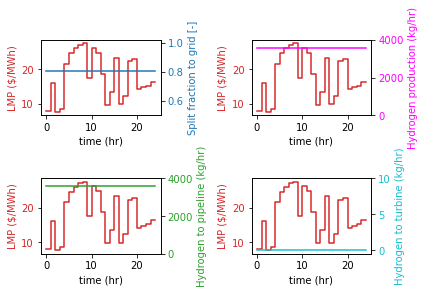

In [24]:
import pyomo.environ as pyo

# Print Results
print("Optimal PEM capacity    : ", m.pem_capacity.value * 1e-3, "MW")
print("Optimal tank capacity   : ", m.tank_capacity.value * 2.016e-3, "kg")
print("OPtimal turbine capacity: ", m.h2_turbine_capacity.value * 1e-6, "MW")

print("NPV :", pyo.value( m.obj ) * 1e-9, "$B")

# Using `generate_plots` we plot optimal operating conditions for a specific day
generate_plots(m, d=1, y=2022, set_time=m.set_time, lmp=m.LMP)

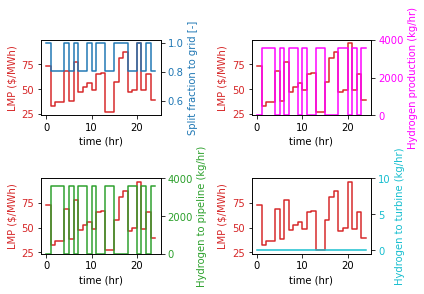

In [25]:
# Using `generate_plots` we plot optimal operating conditions for a specific day
generate_plots(m, d=8, y=2022, set_time=m.set_time, lmp=m.LMP)


- Clearly, when the selling price of hydrogen is $3/kg, it is attractive (maximizes NPV) to produce hydrogen using a portion of electricity when its price is sufficiently low.
- However, storing hydrogen and combusting it later to produce electricity is not attractive. This is inferred from the optimal size of the hydrogen tank and the size of the turbine, respectively (both the values are zero. We see a small nonzero value because we imposed small nonzero lower bounds on flows to avoid convergence issues). 

The optimal size of the PEM electrolyzer for the production of hydrogen is 196.26 MW for a hydrogen demand of 1 kg/s. The hydrogen tank and the hydrogen turbine must not be built to maximize the NPV. The hydrogen produced by the PEM electrolyzer must be sold immediately to the hydrogen market via the pipeline.

In [26]:
# These optimization problems tend to be very large, so we 
# delete the model after analyzing the results to save memory.
del m

## Multiperiod Optimization Model: Stochastic

### LMP Signal

As mentioned in the previous section, due to uncertainty in various factors such as weather, demand, etc., it is not possible to determine the future locational marginal price accurately. There are many approaches to take into account the uncertainty in the LMP signal during the decision making process. One such approach involves the generation of potential LMP scenarios along with their associated probabilities and use them to formulate a stochastic program.

Here, for demonstration, we consider two different realizations of the LMP signal (i.e., two scenarios: scenario 0 and scenario 1). 

In [27]:
# Gather the LMP data needed for the stochastic case
# Notation: lmp_dataset[scenario][year][cluster/day][time/hour]
lmp_stochastic = {scenario: {year: {cluster: {hour: lmp_dataset[str(scenario)][str(year)][str(cluster)][str(hour)]
                                              for hour in range(1, 25)} 
                                    for cluster in range(1, 21)}
                             for year in [2022]}
                  for scenario in [0, 1]}

Next, we formulate an optimization problem of the form
$$ \begin{aligned}
\max_{D, D_s, u_{s, t, d}} \quad & \sum_s w_s \text{NPV}_s(D_s, u_{s, t, d})\\
& g(u_{s, t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}  \\
& h(u_{s, t, d}) \le 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}  \\
& f(u_{s, t-1, d}, u_{s, t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S} \\
& u_{s, t, d} \le D_s, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}\\
& D_s = D, & & \forall\; s \in \mathcal{S}
\end{aligned}$$

Here, the sets $\mathcal{S} = \{0, 1\}$, $\mathcal{T} = \{1, \dots, 24\}$ and $\mathcal{C} = \{1, \dots, 20\}$ denote the the set of scenarios, the set of hours in a day and the set of clusters/days in a year, respectively. $D$ denotes the design decisions (or, first-stage variables) viz. size of the PEM electrolyzer (`pem_capacity`), tank (`tank_capacity`) and the turbine (`turbine_capacity`), and $D_s$ denotes the design decisions in scenario $s$. $u_{s, t, d}$ denotes the operating decisions (or, second-stage decisions) in scenario $s$, at time $t$ of day/cluster $d$. $g(u_{s, t, d}) = 0$ and $h(u_{s, t,d}) \le 0$ denote the flowsheet model, $f(u_{s, t-1,d}, u_{s, t,d}) = 0$ connects the operating decisions at time $t-1$ and at time $t$ (e.g., tank holdup), and $u_{s, t, d} \le D_s$ ensures that the operating decision values never exceed the design capacity values (e.g., tank holdup at any time instant must not exceed the tank capacity) in scenario $s$. Finally, $D_s = D$ ensures that the design decisions are maintained the same in all scenarios (non-anticipativity constraints).

In the objective function, $w_s$ denotes the probability associated with scenario $s$, and $\text{NPV}_s$ stands for the net present value calculated in scenario $s$.

In [28]:
# Create concrete model object
m = ConcreteModel()

# Define sets
m.set_time = RangeSet(24)                    # twenty fours in a day
m.set_days = RangeSet(20)                    # twenty clusters/days per year
m.set_years = [2022]                         # Set of years
m.set_scenarios = [0, 1]                     # Set of scenarios

# Define parameters
m.plant_life = 20                            # Plant lifetime: 20 years
m.tax_rate = 0.2                             # Corporate tax rate: 20%
m.discount_rate = 0.08                       # Discount rate: 8%
m.h2_price = 3                               # Selling price of hydrogen: $3/kg
m.h2_demand = 1                              # Maximum amount of hydrogen that can be sold: 1 kg/s
m.LMP = lmp_stochastic                       # LMP signal
m.weights_days = weights_days                # number of days represented by each cluster
m.weights_scenarios = {0: 0.5, 1: 0.5}       # Equal probability for both the scenarios

Next, we call the `build_multiperiod_design` function to formulate the multi-period optimization problem. However, this time, we also set `stochastic=True`. 

In [29]:
# Build initialized multiperiod model: Constraints g(u(t,d)) = 0 and h(u(t,d)) <= 0
build_multiperiod_design(m,
                         flowsheet=build_ne_flowsheet,
                         initialization=fix_dof_and_initialize,
                         unfix_dof=unfix_dof,
                         multiple_days=True,
                         multiyear=True,
                         stochastic=True,
                         verbose=False)

[    0.00] Processing input information.
[+   0.00] Beginning the formulation of the multiperiod problem.
[+ 154.66] Completed the formulation of the multiperiod problem
2022-08-29 06:40:35 [INFO] idaes.init.fs.pem.outlet_state: Starting initialization
2022-08-29 06:40:35 [INFO] idaes.init.fs.pem.outlet_state: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:40:35 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
2022-08-29 06:40:35 [INFO] idaes.init.fs.h2_tank.properties_in: Starting initialization
2022-08-29 06:40:35 [INFO] idaes.init.fs.h2_tank.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:40:35 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Starting initialization
2022-08-29 06:40:35 [INFO] idaes.init.fs.h2_tank.properties_out_turbine: Property initialization: optimal - Optimal Solution Found.
2022-08-29 06:40:35 [INFO] idaes.init.fs.h2_tank.properties_out

Next, add the connecting constraints and hydrogen demand constraints for each of the scenarios.

In [30]:
for s in m.set_scenarios:
    # Build the connecting constraints
    build_connecting_constraints(m.scenario[s], 
                                 set_time=m.set_time, 
                                 set_days=m.set_days,
                                 set_years=m.set_years)

    # Append cash flow expressions
    append_costs_and_revenue(m.scenario[s],
                             ps=m,
                             LMP=m.LMP[s])
    
    # Hydrogen demand constraint. 
    # Divide the RHS by the molecular mass to convert kg/s to mol/s
    obj = m.scenario[s]
    @obj.Constraint(m.set_time, m.set_days, m.set_years)
    def hydrogen_demand_constraint(blk, t, d, y):
        return blk.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0] <= m.h2_demand / 2.016e-3

In [31]:
# Add non-anticipativity constraints
m.pem_capacity = Var(within=NonNegativeReals,
                     doc="Design PEM capacity (in kW)")
m.tank_capacity = Var(within=NonNegativeReals,
                      doc="Design tank capacity (in mol)")
m.h2_turbine_capacity = Var(within=NonNegativeReals,
                            doc="Design turbine capacity (in W)")

@m.Constraint(m.set_scenarios)
def non_anticipativity_pem(blk, s):
    return blk.pem_capacity == blk.scenario[s].pem_capacity

@m.Constraint(m.set_scenarios)
def non_anticipativity_tank(blk, s):
    return blk.tank_capacity == blk.scenario[s].tank_capacity

@m.Constraint(m.set_scenarios)
def non_anticipativity_turbine(blk, s):
    return blk.h2_turbine_capacity == blk.scenario[s].h2_turbine_capacity

In [32]:
# Define the objective function
m.obj = Objective(expr=sum(m.weights_scenarios[s] * m.scenario[s].npv
                           for s in m.set_scenarios), 
                  sense=maximize)

# Define the solver object. Using the default solver: IPOPT
solver = get_solver()

# Solve the optimization problem
solver.solve(m, tee=True)

Ipopt 3.14.7: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.7, running with linear solver MUMPS 5.5.0.

Number of nonzeros in equality constraint Jacobian...:   580772
Number of nonzeros in inequality constraint Jacobian.:     7680
Number of nonzeros in Lagrangian Hessian.............:   195840

Total number of variables............................:   211209
                     variables with only lower bounds:    20169
                variables with lower and upper bounds:   176640
                     variables with only upper bounds:        0
Total number of equality constrain

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 212166, 'Number of variables': 211209, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.7\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 368.75286197662354}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [33]:
# Print Results
print("Optimal PEM capacity    : ", m.pem_capacity.value * 1e-3, "MW")
print("Optimal tank capacity   : ", m.tank_capacity.value * 2.016e-3, "kg")
print("OPtimal turbine capacity: ", m.h2_turbine_capacity.value * 1e-6, "MW")

Optimal PEM capacity    :  196.2616021918545 MW
Optimal tank capacity   :  1.4179083742965303e-05 kg
OPtimal turbine capacity:  9.0763746194857e-05 MW


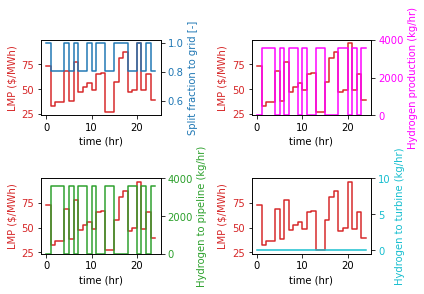

In [34]:
generate_plots(m.scenario[0], d=8, y=2022, set_time=m.set_time, lmp=m.LMP[0])

Even in the stochastic case, we observe the same result i.e., producing hydrogen and selling it during the periods of low electricity demand is profitable. Whereas, building a turbine to combust hydrogen and produce electricity is not attractive. 